### Requirements:
1. Introduction about the dataset
2. What is the goal
3. Preprocessing text
4. Visualization
5. Report

### Rubric:
1. Definition of the dataset - Comprehensive and clear definition
2. Visualization of the Dataset Features and Results - Detailed and insightful visualizations
3. Cleaning the Text Document with Two Approaches - Effective use of two distinct cleaning approaches, with clear explanations
4. Implementation of Three Word Embedding Methods - Comprehensive and effective implementation of three methods, including one
with SpaCy
5. Comparison of the Results of Word Embedding Methods - In-depth and insightful comparison, with clear findings
6. Report and Description of Work Done - Comprehensive and well-structured report, clearly describing all aspects of the
project

## Definition of the dataset

- Dataset about amotional analysis contains 422,000 sentences with 6 emotions: joy, sadness, anger, fear, love and surprise.
- Dataset: from kaggle link https://www.kaggle.com/datasets/kushagra3204/sentiment-and-emotion-analysis-dataset/data

## Preprocessing
- Import libraries
- Download and load dataset using kagglehub library
- Download word2vec model
- Enable GPU if available

In [1]:
import os
import kagglehub
import time
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
import torch
import numpy as np
from wordcloud import WordCloud
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import gensim.downloader as api
from sklearn.feature_extraction.text import TfidfVectorizer 

RANDOM_STATE = 999
BATCH_SIZE = 512
EPOCHS = 50
NUM_RECORDS = 10000

device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda:0" if torch.cuda.is_available() else 
                      "cpu")

# Download latest version
path = kagglehub.dataset_download("kushagra3204/sentiment-and-emotion-analysis-dataset") 
df = pd.read_csv( path +  os.path.sep + 'archive' + os.path.sep + 'combined_emotion.csv') 
# limit
df = df.sample(n=NUM_RECORDS, random_state=RANDOM_STATE)

# Word2Vec Model
word2vec_model = api.load("word2vec-google-news-300")

# Enable GPU if available
if spacy.require_gpu():
    print("GPU is enabled!")
else:
    print("GPU not available.")


GPU is enabled!


## Visualize Dataset
- Show dataset count by emotion.
- Show distribution of sentence length by emotion. 

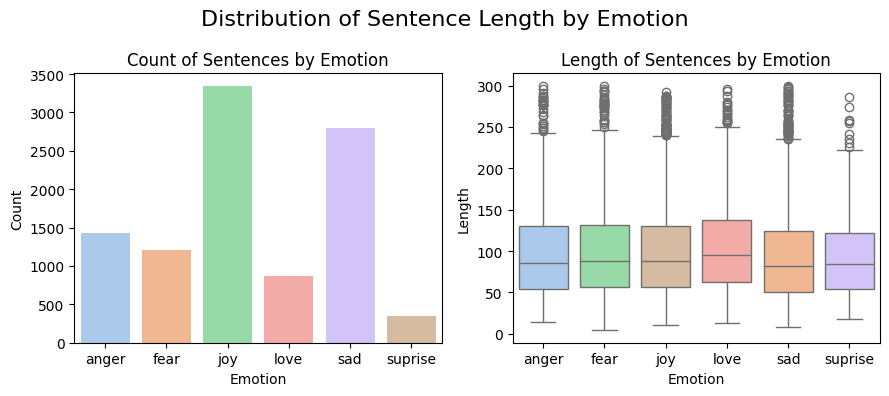

In [2]:
# Visualization
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

sns.set_palette('pastel')
sns.barplot(x='emotion', y='sentence', 
            data=df.groupby('emotion').count(), 
            ax=ax[0], 
            hue='emotion')
ax[0].set_title('Count of Sentences by Emotion')
ax[0].set_xlabel('Emotion')
ax[0].set_ylabel('Count')

# Show distribution of sentence length by emotion
df['len'] = df['sentence'].apply(len)
sns.boxplot(y='len', x='emotion', 
            data=df, 
            ax=ax[1], 
            hue='emotion', 
            order=sorted(df['emotion'].unique()))  
ax[1].set_title('Length of Sentences by Emotion')
ax[1].set_xlabel('Emotion')
ax[1].set_ylabel('Length')
plt.suptitle('Distribution of Sentence Length by Emotion', fontsize=16)
plt.tight_layout()
plt.show()

# Drop unused columns
df.drop(columns=['len'], inplace=True)


### Spacy Pipelines
1. Pipeline 1: 
   - Tokenization, Lowercase
2. Pipeline 2: 
   - Tokenization, Lowercase, Lemmatization  
   - then remove Punctuation, Space, Digit, Currency, Quote, Bracket.

- Process pipeline 1 and 2 in batches.
- Split data into train, validation and test set with ratio 60%, 20%, 20% respectively.

In [3]:
# Decorator to measure time of the function
def measure_time(description):
    def decorator(func):
        def wrapper(*args, **kwargs):
            start_time = time.time()
            result = func(*args, **kwargs)
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"{description:<33}: {execution_time:>10.2f} seconds")
            return result, execution_time
        return wrapper
    return decorator

# Setup pipeline for cleaning text
@spacy.language.Language.component("pipeline1_cleaner")
def pipeline2_cleaner(doc):
    # Process multiple tokens at once
    tokens = [token.text.lower() for token in doc]
    return spacy.tokens.Doc(doc.vocab, words=tokens)

@spacy.language.Language.component("pipeline2_cleaner")
def pipeline2_cleaner(doc):
    # Process multiple tokens at once
    tokens = [token.lemma_.lower() for token in doc 
             if  not token.is_punct 
             and not token.is_space
             and not token.is_digit
             and not token.is_currency
             and not token.is_quote
             and not token.is_bracket]
    return spacy.tokens.Doc(doc.vocab, words=tokens)

def setup_pipeline():
    nlp1 = spacy.load('en_core_web_sm', disable=['tok2vec','ner', 'parser', 
                                                 'attribute_ruler', 
                                                 'tagger','lemmatizer'])
    nlp2 = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
    nlp1.add_pipe("pipeline1_cleaner", last=True)
    nlp2.add_pipe("pipeline2_cleaner", last=True)
    return nlp1, nlp2

def process_batch(texts, model, batch_size=2500):
    return list(model.pipe(texts, batch_size=batch_size))

def process_pipeline(texts, model): 
    # Process in batches
    docs = process_batch(texts, model)
    return [' '.join([token.text for token in doc]) for doc in docs]


@measure_time("Prepare Data")
def prepare_data(train_ds, val_ds,test_ds, nlp1, nlp2):
    # Prepare Train data - Pipeline 1 and 2
    train_ds['pipeline_1'] = process_pipeline(train_ds['sentence'].tolist(), nlp1)
    train_ds['pipeline_2'] = process_pipeline(train_ds['sentence'].tolist(), nlp2)
    
    val_ds['pipeline_1'] = process_pipeline(val_ds['sentence'].tolist(), nlp1)
    val_ds['pipeline_2'] = process_pipeline(val_ds['sentence'].tolist(), nlp2)

    # Prepare Test data - Pipeline 1 and 2
    test_ds['pipeline_1'] = process_pipeline(test_ds['sentence'].tolist(), nlp1)
    test_ds['pipeline_2'] = process_pipeline(test_ds['sentence'].tolist(), nlp2)
    
    # Prepare result dataset
    train_y = train_ds['emotion'].values
    val_y = val_ds['emotion'].values
    test_y = test_ds['emotion'].values
   
    # Drop unused columns
    train_ds.drop(columns=['sentence'], inplace=True)
    test_ds.drop(columns=['sentence'], inplace=True)
    val_ds.drop(columns=['sentence'], inplace=True)
    
    return train_ds, val_ds, test_ds, train_y, val_y, test_y

le = LabelEncoder() 
df['emotion'] = le.fit_transform(df['emotion'])

nlp1, nlp2 = setup_pipeline()
train_val_ds, test_ds = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
train_ds    , val_ds  = train_test_split(train_val_ds, test_size=0.25, random_state=RANDOM_STATE)
(train_ds, val_ds, test_ds, train_y , val_y , test_y), _ = prepare_data(train_ds, val_ds, test_ds, nlp1, nlp2)

Prepare Data                     :       4.42 seconds


## Visualization after pipeline 1 and 2
- Compare word cloud between pipeline 1 and 2.

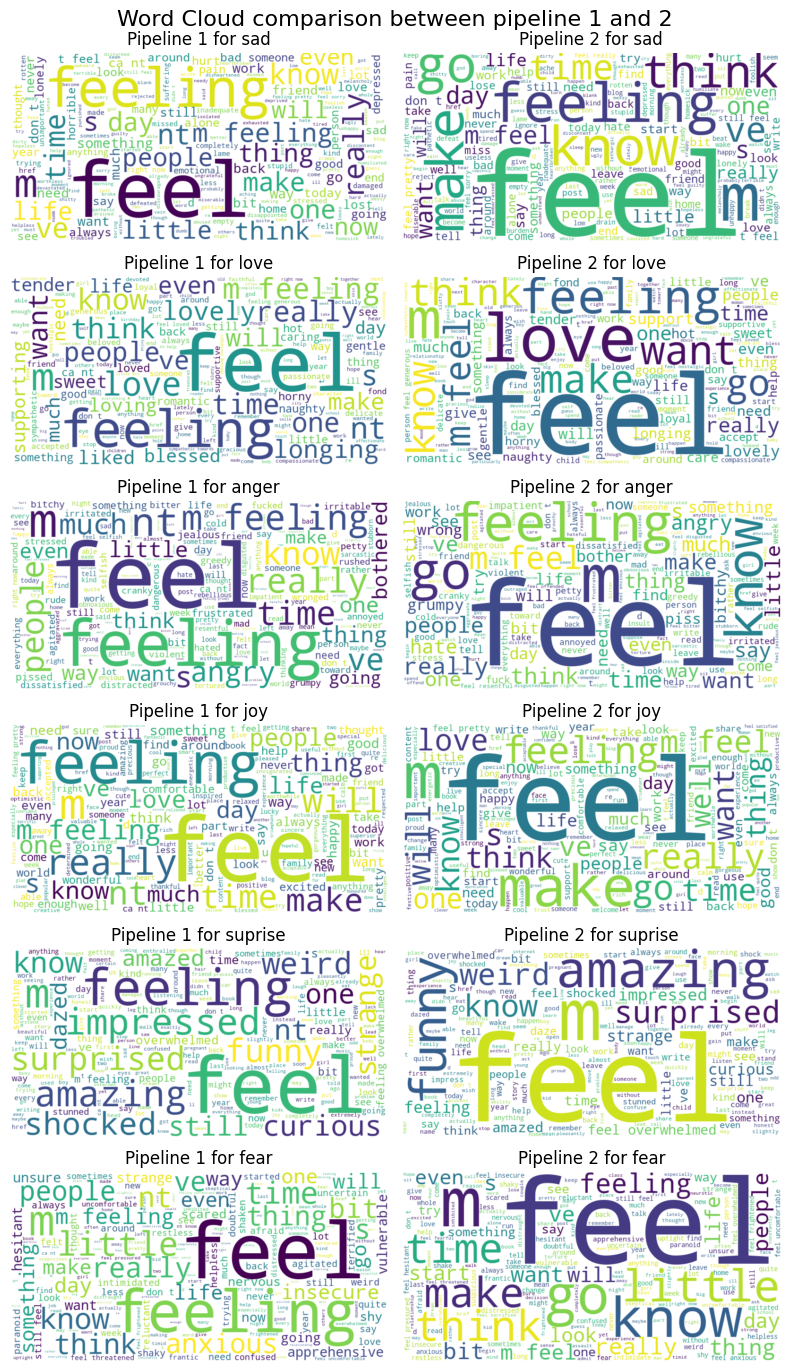

In [4]:
fig, ax = plt.subplots(6, 2, figsize=(8, 14))
concat_df = pd.concat([train_ds, test_ds, val_ds])
for i, emotion in enumerate(concat_df['emotion'].unique()):
    sentences1 = concat_df[concat_df['emotion'] == emotion]['pipeline_1'].tolist()
    sentences2 = concat_df[concat_df['emotion'] == emotion]['pipeline_2'].tolist()
    wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(sentences1))
    wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(sentences2))
    ax[i, 0].imshow(wordcloud1, interpolation='bilinear')
    ax[i, 1].imshow(wordcloud2, interpolation='bilinear')
    ax[i, 0].set_title(f'Pipeline 1 for {le.classes_[emotion]}')
    ax[i, 1].set_title(f'Pipeline 2 for {le.classes_[emotion]}')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.suptitle('Word Cloud comparison between pipeline 1 and 2', fontsize=16)
plt.tight_layout()
plt.show()

## Word Embeddings
1. ```Word2Vec``` - Pretrained Word2Vec model from Google
2. ```TF-IDF``` - TF-IDF Vectorizer from sklearn
3. ```Spacy``` Embeddings - Spacy's pre-trained embeddings (GloVe)

In [5]:
@measure_time("Embedding Word2Vec")
def embedding_word2vec(train_ds, val_ds, test_ds):
    def get_word_vector(word, model, vector_size=300):
        try:
            return model[word]
        except KeyError:
            return np.zeros(vector_size)
    def safe_mean(vector_list, vector_size=300):
        if vector_list:
            return np.mean(vector_list, axis=0)
        else:
            return np.zeros(vector_size)
        
    train_a1_X1 = np.array([safe_mean([get_word_vector(word, word2vec_model) for word in text.split()]) for text in train_ds['pipeline_1']])
    train_a1_X2 = np.array([safe_mean([get_word_vector(word, word2vec_model) for word in text.split()]) for text in train_ds['pipeline_2']])
    
    val_a1_X1 = np.array([safe_mean([get_word_vector(word, word2vec_model) for word in text.split()]) for text in val_ds['pipeline_1']])
    val_a1_X2 = np.array([safe_mean([get_word_vector(word, word2vec_model) for word in text.split()]) for text in val_ds['pipeline_2']])
    
    test_a1_X1 = np.array([safe_mean([get_word_vector(word, word2vec_model) for word in text.split()]) for text in test_ds['pipeline_1']])
    test_a1_X2 = np.array([safe_mean([get_word_vector(word, word2vec_model) for word in text.split()]) for text in test_ds['pipeline_2']])
    
    return train_a1_X1, train_a1_X2, val_a1_X1, val_a1_X2, test_a1_X1, test_a1_X2
    
@measure_time("Embedding TF-IDF")
def embedding_tfidf(train_ds, val_ds, test_ds):
    vectorizer1 = TfidfVectorizer()
    vectorizer2 = TfidfVectorizer()
    
    corpus_1 = pd.concat([train_ds['pipeline_1'], test_ds['pipeline_1'], val_ds['pipeline_1']])
    corpus_2 = pd.concat([train_ds['pipeline_2'], test_ds['pipeline_2'], val_ds['pipeline_2']])
    
    vectorizer1.fit_transform(corpus_1) 
    vectorizer2.fit_transform(corpus_2) 
    
    train_a2_X1 = np.array(vectorizer1.transform(train_ds['pipeline_1']).toarray()) 
    train_a2_X2 = np.array(vectorizer2.transform(train_ds['pipeline_2']).toarray()) 
    
    test_a2_X1 = np.array(vectorizer1.transform(test_ds['pipeline_1']).toarray()) 
    test_a2_X2 = np.array(vectorizer2.transform(test_ds['pipeline_2']).toarray())
    
    val_a2_X1 = np.array(vectorizer1.transform(val_ds['pipeline_1']).toarray()) 
    val_a2_X2 = np.array(vectorizer2.transform(val_ds['pipeline_2']).toarray())
    
    # Free memory
    del vectorizer1, vectorizer2, corpus_1, corpus_2

    return train_a2_X1, train_a2_X2, val_a2_X1, val_a2_X2, test_a2_X1, test_a2_X2

@measure_time("Embedding spaCy")
def embedding_spacy(train_ds, val_ds, test_ds):
    spacy_model = spacy.load('en_core_web_lg') 
    spacy_model.select_pipes(enable=['tok2vec'])
    
    train_a3_X1 = np.array([doc.vector for doc in spacy_model.pipe(train_ds['pipeline_1'])])
    train_a3_X2 = np.array([doc.vector for doc in spacy_model.pipe(train_ds['pipeline_2'])])
    
    test_a3_X1 = np.array([doc.vector for doc in spacy_model.pipe(test_ds['pipeline_1'])])
    test_a3_X2 = np.array([doc.vector for doc in spacy_model.pipe(test_ds['pipeline_2'])])
    
    val_a3_X1 = np.array([doc.vector for doc in spacy_model.pipe(val_ds['pipeline_1'])])
    val_a3_X2 = np.array([doc.vector for doc in spacy_model.pipe(val_ds['pipeline_2'])])

    return train_a3_X1, train_a3_X2, val_a3_X1, val_a3_X2, test_a3_X1, test_a3_X2


# Embedding word2vec, BOW, and GloVe
(train_a1_X1, train_a1_X2, val_a1_X1, 
   val_a1_X2, test_a1_X1, test_a1_X2), time_w2v   = embedding_word2vec(train_ds, val_ds, test_ds)
(train_a2_X1, train_a2_X2, val_a2_X1, 
   val_a2_X2, test_a2_X1, test_a2_X2), time_tf    = embedding_tfidf(train_ds, val_ds, test_ds)
(train_a3_X1, train_a3_X2, val_a3_X1, 
   val_a3_X2, test_a3_X1, test_a3_X2), time_spacy = embedding_spacy(train_ds, val_ds, test_ds)


Embedding Word2Vec               :       0.40 seconds
Embedding TF-IDF                 :       0.90 seconds
Embedding spaCy                  :       4.11 seconds


## Visualize features of each technique
- Time use to embed the data by technique.
- Number of features generated by each technique.
- Distance between two vectors on the same emotion.
    - Euclidean distance between two vectors on the same emotion.
    - Cosine distance between two vectors on the same emotion.

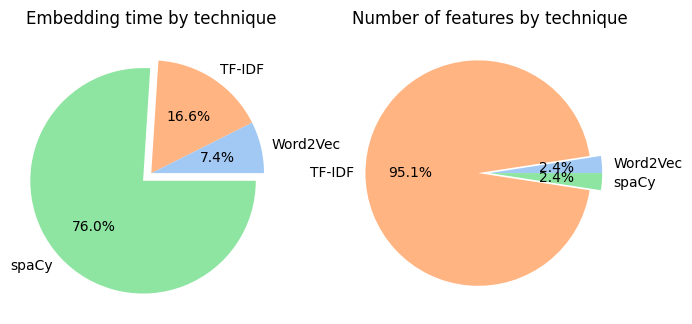

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].pie([time_w2v, time_tf, time_spacy], 
        labels=['Word2Vec', 'TF-IDF', 'spaCy'], 
        autopct='%1.1f%%',
        explode=[0, 0, 0.1])
ax[0].set_title('Embedding time by technique')

ax[1].pie([len(train_a1_X1[0]), len(train_a2_X1[0]), len(train_a3_X1[0])], 
        labels=['Word2Vec', 'TF-IDF', 'spaCy'], 
        autopct='%1.1f%%', 
        explode=[0, 0.1, 0])
ax[1].set_title('Number of features by technique')

plt.show()

## Standardization
- Standardize all embedding vectors.

In [7]:
@measure_time("Standardization")
def standardize_data(train_input, val_input, test_input, eps=1e-8):
    # epsilon is to avoid division by zero for BoW with zero variance column.
    std = train_input.std(axis=0)
    std_adj = np.where(std < eps, eps, std)
    mean = train_input.mean(axis=0) 
    scaler = StandardScaler(copy=False) 
    scaler.mean_ = mean
    scaler.scale_ = std_adj
    
    train_input = scaler.transform(train_input)
    val_input = scaler.transform(val_input)
    test_input = scaler.transform(test_input)
    
    return train_input, val_input, test_input

print('Standardization for Word2Vec')
(train_a1_X1, val_a1_X1, test_a1_X1), time_a1_X1 = standardize_data(train_a1_X1, val_a1_X1, test_a1_X1)
(train_a1_X2, val_a1_X2, test_a1_X2), time_a1_X2 = standardize_data(train_a1_X2, val_a1_X2, test_a1_X2)

print('Standardization for TF-IDF')
(train_a2_X1, val_a2_X1, test_a2_X1), time_a2_X1 = standardize_data(train_a2_X1, val_a2_X1, test_a2_X1)
(train_a2_X2, val_a2_X2, test_a2_X2), time_a2_X2 = standardize_data(train_a2_X2, val_a2_X2, test_a2_X2)

print('Standardization for spaCy')
(train_a3_X1, val_a3_X1, test_a3_X1), time_a3_X1 = standardize_data(train_a3_X1, val_a3_X1, test_a3_X1)
(train_a3_X2, val_a3_X2, test_a3_X2), time_a3_X2 = standardize_data(train_a3_X2, val_a3_X2, test_a3_X2) 

Standardization for Word2Vec
Standardization                  :       0.01 seconds
Standardization                  :       0.01 seconds
Standardization for TF-IDF
Standardization                  :       0.30 seconds
Standardization                  :       0.20 seconds
Standardization for spaCy
Standardization                  :       0.00 seconds
Standardization                  :       0.00 seconds


## Train multiclass classification model
- Train model with train data and validate with validation data.
- Evaluate model with test data.
- Compare accuracy between different models.
- Plot accuracy and loss over epochs.
- Plot confusion matrix.

In [29]:
# Define Dataset Class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, label_data):
        self.input_data = input_data
        self.label_data = label_data
        
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        return self.input_data[idx], self.label_data[idx]

# Define MultiClass Classification Network Class
class MultiClassNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MultiClassNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def train_model(input_data, val_data, device, epochs=EPOCHS):
    
    input_dataset = torch.utils.data.DataLoader(input_data, batch_size=BATCH_SIZE, shuffle=True)
    val_dataset = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
    model = MultiClassNet(input_size=input_dataset.dataset[0][0].shape[0], hidden_size=256, output_size=6)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)
    
    loss_list = []
    accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
    progress = tqdm(range(epochs), total=epochs, desc="Training Progress", leave=False)
    for _ in progress:
        
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0
        num_batches = 0
        
        for inputs, labels in input_dataset:
            inputs = inputs.float().to(device) 
            labels = labels.long().to(device) 
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
             
            # Update running loss
            predicted = torch.argmax(outputs, 1)
            running_loss += loss.item()
            running_correct += (predicted == labels).sum().item()
            running_total += labels.shape[0]
            num_batches += 1
        # Calculate average loss for the epoch
        avg_loss = running_loss / num_batches
        avg_accuracy = running_correct / running_total
        loss_list.append(avg_loss) 
        accuracy_list.append(avg_accuracy)
        
        # Calculate accuracy for this epoch
        model.eval()
        val_running_correct = 0
        val_running_loss = 0
        val_running_total = 0
        num_batches = 0
        with torch.no_grad():
            for inputs, labels in val_dataset:
                inputs = inputs.float().to(device)
                labels = labels.long().to(device)
                outputs = model(inputs)
                predicted = torch.argmax(outputs, 1)
                val_running_loss += criterion(outputs, labels).item()
                val_running_correct += (predicted == labels).sum().item()
                val_running_total += labels.shape[0]
                num_batches += 1
        val_loss = val_running_loss / num_batches
        val_accuracy = val_running_correct / val_running_total
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        progress.set_postfix({'train_loss': avg_loss, 'train_accuracy': avg_accuracy, 'val_loss': val_loss, 'val_accuracy': val_accuracy})
    return model, loss_list, accuracy_list, val_loss_list, val_accuracy_list

@measure_time("Training model pair")
def train_model_pair(input_data_1, input_data_2, val_data_1, val_data_2, input_label, val_label, device):
    
    model_1, loss_1, accuracy_1, val_loss_1, val_accuracy_1 = \
        train_model(CustomDataset(input_data_1, input_label), CustomDataset(val_data_1, val_label), device)
    model_2, loss_2, accuracy_2, val_loss_2, val_accuracy_2 = \
        train_model(CustomDataset(input_data_2, input_label), CustomDataset(val_data_2, val_label), device)
        
    return model_1, model_2, loss_1, loss_2, accuracy_1, accuracy_2, val_loss_1, val_loss_2, val_accuracy_1, val_accuracy_2
    
def evaluate_matrix(model, test_input, device):
    test_data = torch.utils.data.DataLoader(test_input, batch_size=BATCH_SIZE)
    
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for _, (inputs, labels) in enumerate(test_data):
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)
            
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    confusion = confusion_matrix(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    
    return confusion, accuracy

def evaluate_model_pair(model_1, model_2, test_data_1, test_data_2, label_data, device):
    confusion_1, accuracy_1 = evaluate_matrix(model_1, CustomDataset(test_data_1, label_data), device)
    confusion_2, accuracy_2 = evaluate_matrix(model_2, CustomDataset(test_data_2, label_data), device)
    
    return confusion_1, confusion_2, accuracy_1, accuracy_2
    
print('Training model for Word2Vec')    
(model_a1_X1_1, model_a1_X1_2, 
    train_loss_a1_X1, train_loss_a1_X2, 
    train_accuracy_a1_X1, train_accuracy_a1_X2,
    val_loss_a1_X1, val_loss_a1_X2,
    val_accuracy_a1_X1, val_accuracy_a1_X2), time_train_w2v = train_model_pair(train_a1_X1, train_a1_X2, 
                                                                        val_a1_X1, val_a1_X2, 
                                                                        train_y, val_y, device)
confusion_a1_X1, confusion_a1_X2, accuracy_a1_X1, accuracy_a1_X2 = evaluate_model_pair(model_a1_X1_1, model_a1_X1_2, 
                                                                                       test_a1_X1, test_a1_X2, 
                                                                                       test_y, device)

print('Training model for TF-IDF')
(model_a2_X1_1, model_a2_X1_2, 
    train_loss_a2_X1, train_loss_a2_X2, 
    train_accuracy_a2_X1, train_accuracy_a2_X2,
    val_loss_a2_X1, val_loss_a2_X2,
    val_accuracy_a2_X1, val_accuracy_a2_X2), time_train_tf = train_model_pair(train_a2_X1, train_a2_X2, 
                                                                      val_a2_X1, val_a2_X2, 
                                                                      train_y, val_y, device)
confusion_a2_X1, confusion_a2_X2, accuracy_a2_X1, accuracy_a2_X2 = evaluate_model_pair(model_a2_X1_1, model_a2_X1_2, 
                                                                                       test_a2_X1, test_a2_X2, 
                                                                                       test_y, device)

print('Training model for spaCy')
(model_a3_X1_1, model_a3_X1_2, 
    train_loss_a3_X1, train_loss_a3_X2, 
    train_accuracy_a3_X1, train_accuracy_a3_X2,
    val_loss_a3_X1, val_loss_a3_X2,
    val_accuracy_a3_X1, val_accuracy_a3_X2), time_train_spacy = train_model_pair(train_a3_X1, train_a3_X2, 
                                                                         val_a3_X1, val_a3_X2, 
                                                                         train_y, val_y, device)
confusion_a3_X1, confusion_a3_X2, accuracy_a3_X1, accuracy_a3_X2 = evaluate_model_pair(model_a3_X1_1, model_a3_X1_2, 
                                                                                       test_a3_X1, test_a3_X2, 
                                                                                       test_y, device)


Training model for Word2Vec


Training model pair              :       5.56 seconds
Training model for TF-IDF


Training model pair              :      20.13 seconds
Training model for spaCy


Training model pair              :       5.20 seconds


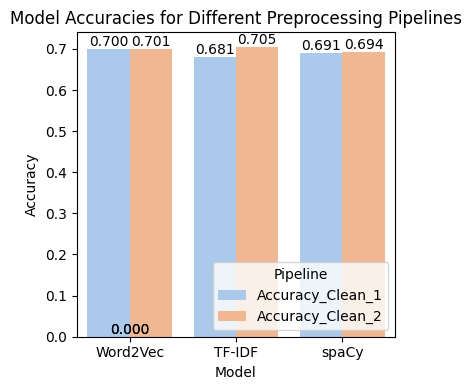

In [30]:
accuracy_df = pd.DataFrame({
    'Model': ['Word2Vec', 'TF-IDF', 'spaCy'],
    'Accuracy_Clean_1': [accuracy_a1_X1, accuracy_a2_X1, accuracy_a3_X1],
    'Accuracy_Clean_2': [accuracy_a1_X2, accuracy_a2_X2, accuracy_a3_X2]
})

# Melt the dataframe for easier plotting
accuracy_df_melted = accuracy_df.melt(id_vars=['Model'], 
                                    value_vars=['Accuracy_Clean_1', 'Accuracy_Clean_2'],
                                    var_name='Accuracy Type', 
                                    value_name='Accuracy')

accuracy_df['Accuracy'] = (accuracy_df['Accuracy_Clean_1'] + accuracy_df['Accuracy_Clean_2'])/ 2
accuracy_df.sort_values(by='Accuracy', ascending=False, inplace=True)

plt.figure(figsize=(4, 4))
ax = sns.barplot(x='Model', y='Accuracy', hue='Accuracy Type', data=accuracy_df_melted)

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')

plt.title('Model Accuracies for Different Preprocessing Pipelines')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.legend(title='Pipeline', loc='lower right')
plt.tight_layout()
plt.show()



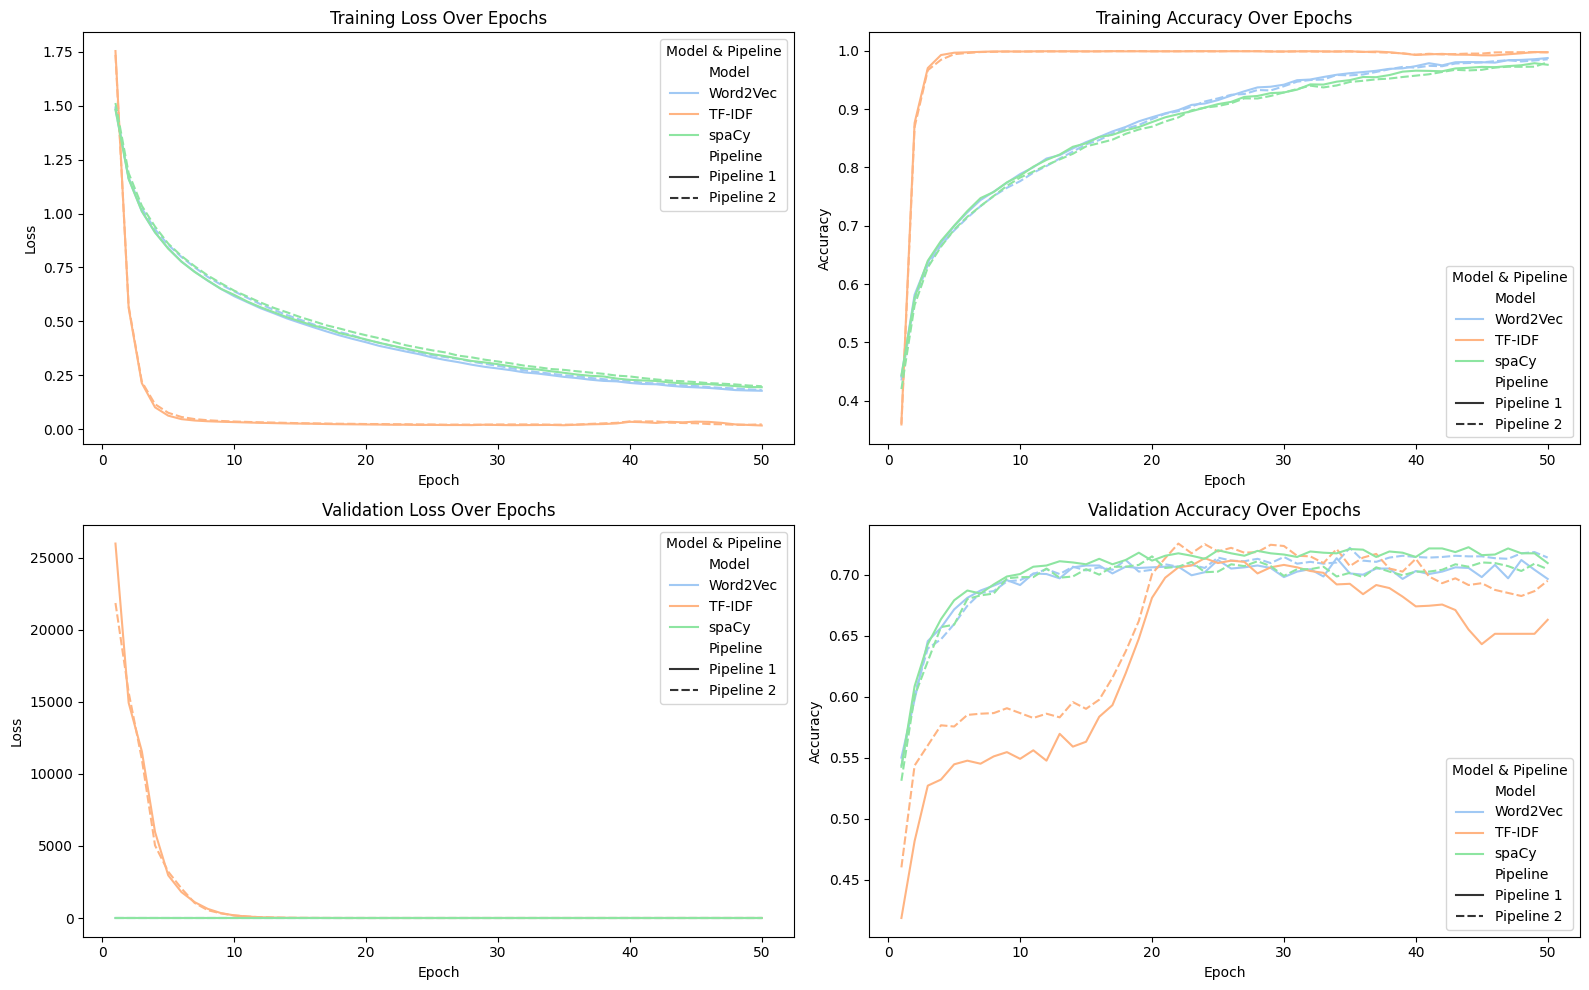

In [31]:
# Create a DataFrame for loss values
# First create lists of equal length
models = ['Word2Vec'] * len(train_loss_a1_X1) + ['Word2Vec'] * len(train_loss_a1_X2) + \
         ['TF-IDF'] * len(train_loss_a2_X1) + ['TF-IDF'] * len(train_loss_a2_X2) + \
         ['spaCy'] * len(train_loss_a3_X1) + ['spaCy'] * len(train_loss_a3_X2)
         
pipelines = ['Pipeline 1'] * len(train_loss_a1_X1) + ['Pipeline 2'] * len(train_loss_a1_X2) + \
            ['Pipeline 1'] * len(train_loss_a2_X1) + ['Pipeline 2'] * len(train_loss_a2_X2) + \
            ['Pipeline 1'] * len(train_loss_a3_X1) + ['Pipeline 2'] * len(train_loss_a3_X2)
            
epochs = list(range(1, len(train_loss_a1_X1) + 1)) * 6

# Convert loss lists to flat list
losses = []
accuracies = []
val_losses = []
val_accuracies = []
for train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list \
                        in [(train_loss_a1_X1, train_accuracy_a1_X1, val_loss_a1_X1, val_accuracy_a1_X1), 
                            (train_loss_a1_X2, train_accuracy_a1_X2, val_loss_a1_X2, val_accuracy_a1_X2), 
                           (train_loss_a2_X1, train_accuracy_a2_X1, val_loss_a2_X1, val_accuracy_a2_X1), 
                           (train_loss_a2_X2, train_accuracy_a2_X2, val_loss_a2_X2, val_accuracy_a2_X2),
                           (train_loss_a3_X1, train_accuracy_a3_X1, val_loss_a3_X1, val_accuracy_a3_X1), 
                           (train_loss_a3_X2, train_accuracy_a3_X2, val_loss_a3_X2, val_accuracy_a3_X2)]:
    losses.extend(train_loss_list)
    accuracies.extend(train_accuracy_list)
    val_losses.extend(val_loss_list)
    val_accuracies.extend(val_accuracy_list)

# Create DataFrame ensuring all arrays are same length
metrics_df = pd.DataFrame({
    'Model': models,
    'Pipeline': pipelines,
    'Loss': losses,
    'Accuracy': accuracies,
    'Val_Loss': val_losses,
    'Val_Accuracy': val_accuracies,
    'Epoch': epochs
})

fig, ax = plt.subplots(2, 2, figsize=(16, 10))

# Plot Loss
sns.lineplot(data=metrics_df, x='Epoch', y='Loss', hue='Model', style='Pipeline', ax=ax[0, 0])
ax[0, 0].set_title('Training Loss Over Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].legend(title='Model & Pipeline', loc='upper right')

# Plot Accuracy
sns.lineplot(data=metrics_df, x='Epoch', y='Accuracy', hue='Model', style='Pipeline', ax=ax[0, 1])
ax[0, 1].set_title('Training Accuracy Over Epochs')
ax[0, 1].set_ylabel('Accuracy')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].legend(title='Model & Pipeline', loc='lower right')

# Plot Validation Loss
sns.lineplot(data=metrics_df, x='Epoch', y='Val_Loss', hue='Model', style='Pipeline', ax=ax[1, 0])
ax[1, 0].set_title('Validation Loss Over Epochs')
ax[1, 0].set_ylabel('Loss')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].legend(title='Model & Pipeline', loc='upper right')

# Plot Validation Accuracy
sns.lineplot(data=metrics_df, x='Epoch', y='Val_Accuracy', hue='Model', style='Pipeline', ax=ax[1, 1])
ax[1, 1].set_title('Validation Accuracy Over Epochs')
ax[1, 1].set_ylabel('Accuracy')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].legend(title='Model & Pipeline', loc='lower right')


plt.tight_layout()
plt.show()


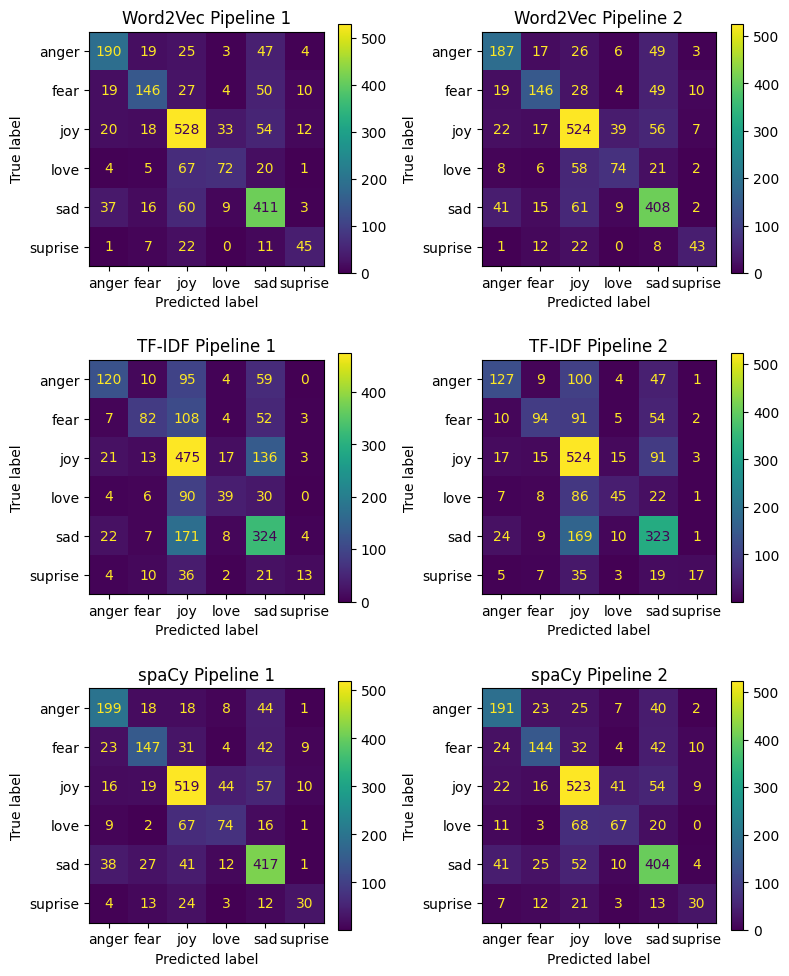

In [17]:
_, ax = plt.subplots(3, 2, figsize=(8, 10))

disp = ConfusionMatrixDisplay(confusion_a1_X1, display_labels=le.classes_)
disp.plot(ax=ax[0, 0])
ax[0, 0].set_title('Word2Vec Pipeline 1')

disp = ConfusionMatrixDisplay(confusion_a1_X2, display_labels=le.classes_)
disp.plot(ax=ax[0, 1])
ax[0, 1].set_title('Word2Vec Pipeline 2')

disp = ConfusionMatrixDisplay(confusion_a2_X1, display_labels=le.classes_)
disp.plot(ax=ax[1, 0])
ax[1, 0].set_title('TF-IDF Pipeline 1')

disp = ConfusionMatrixDisplay(confusion_a2_X2, display_labels=le.classes_)
disp.plot(ax=ax[1, 1])
ax[1, 1].set_title('TF-IDF Pipeline 2')

disp = ConfusionMatrixDisplay(confusion_a3_X1, display_labels=le.classes_)
disp.plot(ax=ax[2, 0])
ax[2, 0].set_title('spaCy Pipeline 1')

disp = ConfusionMatrixDisplay(confusion_a3_X2, display_labels=le.classes_)
disp.plot(ax=ax[2, 1])
ax[2, 1].set_title('spaCy Pipeline 2')

plt.tight_layout()
plt.show()